In [1]:
from setup import general
from setup import stat
from setup import r

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import pingouin as pg
from pingouin import ancova # anconva
from pingouin import multivariate_normality # for pearson correlation
from rpy2 import robjects

/home/jzni/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


<a id="group"></a>
## 患者行为评分与其损伤情况的关联性
患者疼痛评分与损伤位置、损伤节段数、ASIA评分的关联性,因为样本数较少，因此将分类变量转化为二分变量   
* ASIA评分分为D组/非D组* ASIA评分分为D组/非D组
* 损伤位置分为颈髓损伤包括C6/7与不包括两组  
P_006损伤部位记录为C6,根据其他患者的情况来看，损伤节段少的位置较为靠上，故将其归入损伤不包括C6/7的一组中P_006损伤部位记录为C6,根据其他患者的情况来看，损伤节段少的位置较为靠上，故将其归入损伤不包括C6/7的一组中
* 损伤节段数分为3以上/3及以下
* 治疗方案分类大部分是椎前路融合内固定，但其余的组成不同质，既有保守也有手术，故不分组


In [2]:
%store -r Scale_corr_1 nreps

In [3]:
general.fill_na_mean(Scale_corr_1)
for i in Scale_corr_1.index:
    Scale_corr_1.loc[i,'ASIA_Group'] = 1 if Scale_corr_1.loc[i, 'ASIA']=='D' else 0  # AISA_Group: 1 represents D
    Scale_corr_1.loc[i,'PSQ_Group'] = 1 if Scale_corr_1.loc[i, 'PSQ'] > Scale_corr_1['PSQ'].mean() else 0 # PSQ_Group: 1 represents higher than average
Scale_corr_1.head(3)

,timepoint,VAS,SFMPQ,PDQ,PSQ,FPQ_Severe,FPQ_Mild,FPQ_Medical,FPQ_Total,PCS_1,...,BDI,LOT_R,PSQI,Age,ASIA,Injured_seg,Seg_count,Treatment,ASIA_Group,PSQ_Group
ID,,,,,,,,,,,,,,,,,,,,,
P_003,1,50.0,96.0,19.0,41.00,15.00,16.00,18.00,49.00,11.00,...,4.0,26.0,4.0,71,D,1,1,3,1.0,0.0
P_004,1,100.0,150.0,34.0,68.93,32.27,20.18,24.73,77.18,6.64,...,19.0,21.7,4.5,50,C,1,1,1,0.0,1.0
P_006,1,10.0,11.0,3.0,53.00,33.00,14.00,19.00,66.00,6.00,...,3.0,24.0,2.0,68,D,0,0,0,1.0,0.0


### 两组间进行两独立样本t检验

In [4]:
factor_asia = []; factor_injured_seg = []; factor_seg_count = []; factor_psq = []
scale_corrlist_1 = Scale_corr_1.columns[1:-6]

for factor in ['ASIA_Group','Injured_seg','Seg_count','PSQ_Group']:
    group1 = Scale_corr_1[Scale_corr_1[factor]==1] # 大于3、包含C6/7、PSQ高于平均、D级
    group2 = Scale_corr_1[Scale_corr_1[factor]==0] # 不大于3、不包含C6/7、PSQ低于平均、非D级
    for scale in scale_corrlist_1:
        if scale == 'Age':
            break
        lev = stats.levene(group1[scale], group2[scale])
        equal_var = True if lev[1]>0.05 else False
        t_result = stats.ttest_ind(group1[scale], group2[scale], equal_var=equal_var)

        perm_ind_t_p = robjects.r['perm_ind_t'](r.to_csv_r(group1, 'g1', scale), r.to_csv_r(group2, 'g2', scale), 3 + len(scale), nreps=nreps)
        
        # 将年龄作为协变量
        ancova_a = group1[[scale,'Age']]
        ancova_a.loc[:,'Type'] = [1 for i in range(ancova_a.shape[0])]
        ancova_b = group2[[scale,'Age']]
        ancova_b.loc[:,'Type'] = [2 for i in range(ancova_b.shape[0])]
        ancova_df = pd.concat([ancova_a,ancova_b])
        anc = ancova(data=ancova_df, dv=str(scale), between='Type', covar='Age')

        res = list(stats.shapiro(group1[scale])+stats.shapiro(group2[scale])+lev+tuple([round(t_result[0],5),round(t_result[1],5)])+tuple(perm_ind_t_p))
        res.append(anc.loc[0,'p-unc'])
        if factor == 'ASIA_Group':
            factor_asia.append(res)
        elif factor == 'Injured_seg':
            factor_injured_seg.append(res)
        elif factor == 'Seg_count':
            factor_seg_count.append(res)
        elif factor == 'PSQ_Group':
            factor_psq.append(res)

/home/jzni/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/jzni/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/jzni/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [5]:
print("不同损伤节段组间的差异：")
index_corr = scale_corrlist_1[:-1]
injured_seg = pd.DataFrame(factor_injured_seg, index=index_corr, columns=['g1_norm_stat','g1_norm_p', 'g2_norm_stat','g2_norm_p','levene_stat', 'levene_p','ind_t','ind_t_p','perm_ind_t_p','ancova_p'])
injured_seg

不同损伤节段组间的差异：


,g1_norm_stat,g1_norm_p,g2_norm_stat,g2_norm_p,levene_stat,levene_p,ind_t,ind_t_p,perm_ind_t_p,ancova_p
VAS,0.969307,0.884351,0.778985,0.037714,0.025054,0.876494,-0.79974,0.43722,0.4572,0.360523
SFMPQ,0.906603,0.258461,0.833016,0.113983,0.189072,0.670318,0.56935,0.57814,0.5798,0.636778
PDQ,0.913116,0.303085,0.943673,0.688909,0.546842,0.471829,1.03703,0.31730,0.3326,0.414176
PSQ,0.941574,0.570655,0.861002,0.192631,0.612217,0.446987,-1.43608,0.17295,0.1600,0.143177
FPQ_Severe,0.904008,0.242313,0.940032,0.659460,1.993283,0.179837,-0.61054,0.55129,0.5498,0.257945
FPQ_Mild,0.870705,0.101874,0.925180,0.543423,0.236017,0.634613,-0.02147,0.98318,0.9902,0.650410
FPQ_Medical,0.872815,0.107796,0.977750,0.939843,1.931964,0.186250,0.42140,0.67986,0.7028,0.935422
FPQ_Total,0.917321,0.335152,0.913212,0.457859,1.244792,0.283334,-0.11529,0.90985,0.9232,0.469975
PCS_1,0.933043,0.478478,0.639894,0.001351,3.791512,0.071858,0.52775,0.60593,0.6408,0.713234
PCS_2,0.913046,0.302577,0.889979,0.318078,2.233112,0.157276,0.17562,0.86311,0.8832,0.997414


In [6]:
print("不同损伤节段数组间的差异：")
seg_count = pd.DataFrame(factor_seg_count, index=index_corr, columns=['g1_norm_stat','g1_norm_p', 'g2_norm_stat','g2_norm_p','levene_stat', 'levene_p','ind_t','ind_t_p','perm_ind_t_p','ancova_p'])
seg_count

不同损伤节段数组间的差异：


,g1_norm_stat,g1_norm_p,g2_norm_stat,g2_norm_p,levene_stat,levene_p,ind_t,ind_t_p,perm_ind_t_p,ancova_p
VAS,0.976360,0.940079,0.894474,0.221683,0.618145,0.444842,-0.61420,0.54893,0.5534,0.457485
SFMPQ,0.927183,0.527201,0.958854,0.786247,0.266230,0.613924,0.61591,0.54784,0.5536,0.608193
PDQ,0.927795,0.532303,0.906686,0.293362,2.502121,0.136016,1.22094,0.24227,0.2500,0.327434
PSQ,0.947821,0.709830,0.947964,0.667729,0.000135,0.990903,-1.06182,0.30629,0.3128,0.259127
FPQ_Severe,0.867191,0.175382,0.941383,0.596530,3.015471,0.104416,-0.11675,0.90872,0.9106,0.575403
FPQ_Mild,0.903011,0.349605,0.908647,0.306518,1.267852,0.279102,0.63079,0.53834,0.5362,0.765126
FPQ_Medical,0.913807,0.422865,0.917549,0.372331,4.695388,0.047982,0.71825,0.49714,0.4442,0.635236
FPQ_Total,0.938336,0.623784,0.938961,0.571005,3.249626,0.093002,0.40963,0.68828,0.6842,0.967687
PCS_1,0.936546,0.607834,0.884404,0.174611,4.808024,0.045720,0.50499,0.63034,0.6312,0.688136
PCS_2,0.911014,0.402942,0.966632,0.864491,3.626251,0.077631,0.44838,0.66074,0.6950,0.796147


In [8]:
print("不同ASIA评分组间的差异：")
asia_group = pd.DataFrame(factor_asia, index=index_corr, columns=['g1_norm_stat','g1_norm_p', 'g2_norm_stat','g2_norm_p','levene_stat', 'levene_p','ind_t','ind_t_p','perm_ind_t_p','ancova_p'])
asia_group

不同ASIA评分组间的差异：


,g1_norm_stat,g1_norm_p,g2_norm_stat,g2_norm_p,levene_stat,levene_p,ind_t,ind_t_p,perm_ind_t_p,ancova_p
VAS,0.927436,0.353725,0.979725,0.900405,1.241935,0.283865,-2.13085,0.05131,0.0560,0.058612
SFMPQ,0.963877,0.837400,0.916628,0.518213,0.209956,0.653833,-3.70621,0.00235,0.0008,0.003352
PDQ,0.937555,0.467058,0.906028,0.461613,4.861111,0.044697,-1.82652,0.15124,0.0298,0.020501
PSQ,0.940520,0.504841,0.750063,0.038679,0.070987,0.793789,-1.60543,0.13071,0.1364,0.147189
FPQ_Severe,0.937264,0.463467,0.728634,0.023857,0.373690,0.550797,-1.28296,0.22034,0.2246,0.178743
FPQ_Mild,0.902528,0.170989,0.849949,0.225996,0.003047,0.956757,-1.59220,0.13366,0.1308,0.085254
FPQ_Medical,0.843364,0.030429,0.712281,0.015991,0.032855,0.858762,-1.02195,0.32414,0.3462,0.159062
FPQ_Total,0.947560,0.601635,0.835366,0.182231,0.091129,0.767185,-1.36962,0.19237,0.2014,0.098583
PCS_1,0.892329,0.126278,0.629776,0.001241,2.156795,0.164049,-0.08496,0.93349,0.9336,0.967004
PCS_2,0.939021,0.485491,0.629776,0.001241,3.003791,0.105028,0.37361,0.71429,0.7452,0.674116


In [9]:
print("不同PSQ组间的差异：")
psq = pd.DataFrame(factor_asia, index=index_corr, columns=['g1_norm_stat','g1_norm_p', 'g2_norm_stat','g2_norm_p','levene_stat', 'levene_p','ind_t','ind_t_p','perm_ind_t_p','ancova_p'])
psq

不同PSQ组间的差异：


,g1_norm_stat,g1_norm_p,g2_norm_stat,g2_norm_p,levene_stat,levene_p,ind_t,ind_t_p,perm_ind_t_p,ancova_p
VAS,0.927436,0.353725,0.979725,0.900405,1.241935,0.283865,-2.13085,0.05131,0.0560,0.058612
SFMPQ,0.963877,0.837400,0.916628,0.518213,0.209956,0.653833,-3.70621,0.00235,0.0008,0.003352
PDQ,0.937555,0.467058,0.906028,0.461613,4.861111,0.044697,-1.82652,0.15124,0.0298,0.020501
PSQ,0.940520,0.504841,0.750063,0.038679,0.070987,0.793789,-1.60543,0.13071,0.1364,0.147189
FPQ_Severe,0.937264,0.463467,0.728634,0.023857,0.373690,0.550797,-1.28296,0.22034,0.2246,0.178743
FPQ_Mild,0.902528,0.170989,0.849949,0.225996,0.003047,0.956757,-1.59220,0.13366,0.1308,0.085254
FPQ_Medical,0.843364,0.030429,0.712281,0.015991,0.032855,0.858762,-1.02195,0.32414,0.3462,0.159062
FPQ_Total,0.947560,0.601635,0.835366,0.182231,0.091129,0.767185,-1.36962,0.19237,0.2014,0.098583
PCS_1,0.892329,0.126278,0.629776,0.001241,2.156795,0.164049,-0.08496,0.93349,0.9336,0.967004
PCS_2,0.939021,0.485491,0.629776,0.001241,3.003791,0.105028,0.37361,0.71429,0.7452,0.674116


In [10]:
%store injured_seg seg_count asia_group psq

Stored 'injured_seg' (DataFrame)
Stored 'seg_count' (DataFrame)
Stored 'asia_group' (DataFrame)
Stored 'psq' (DataFrame)


/home/jzni/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


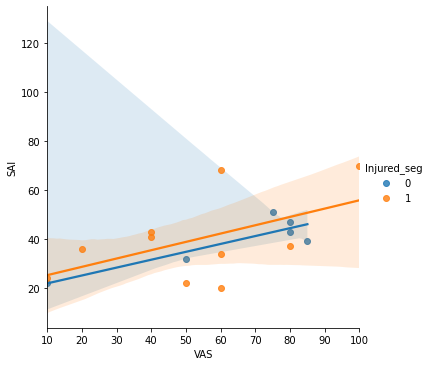

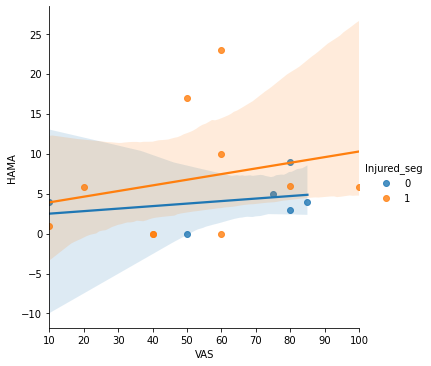

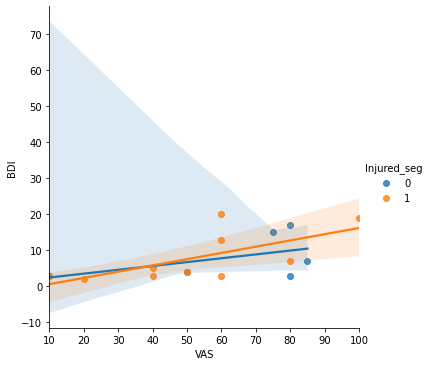

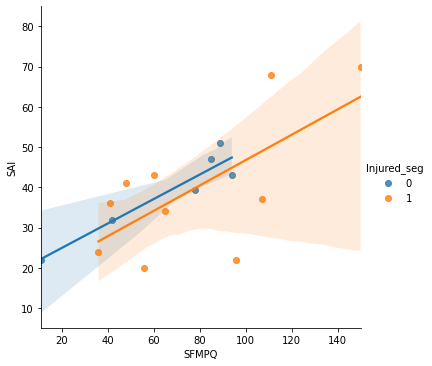

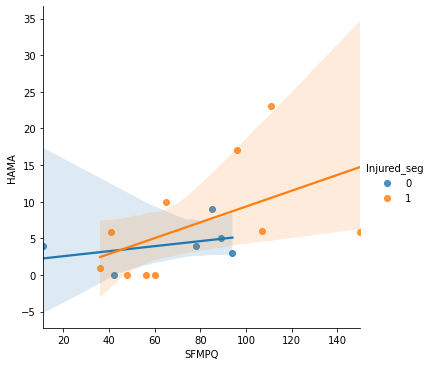

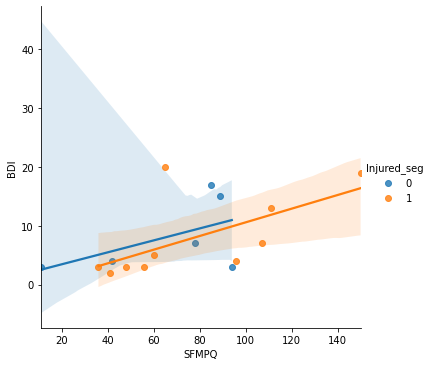

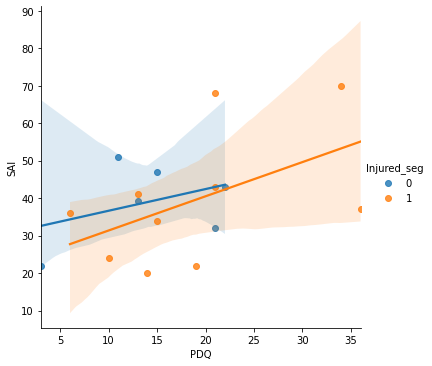

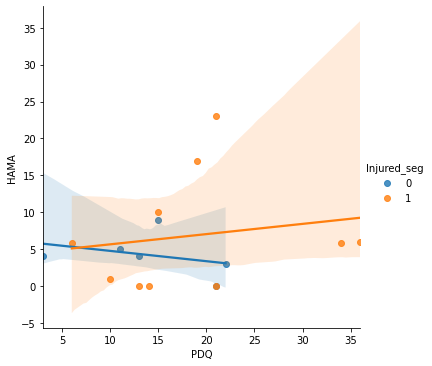

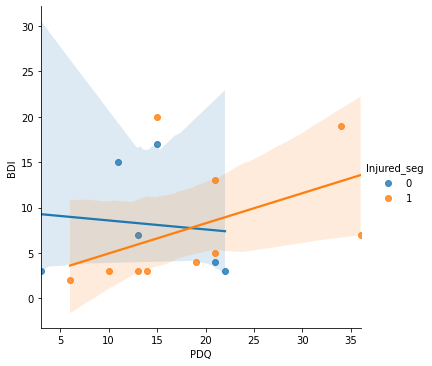

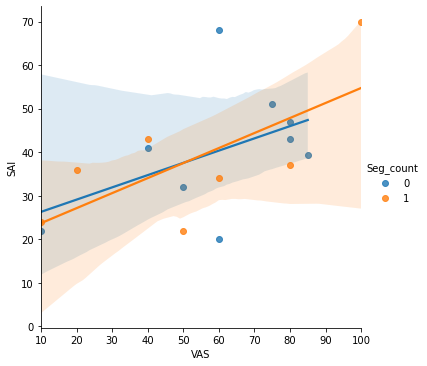

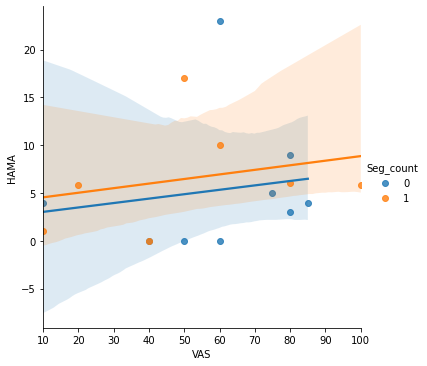

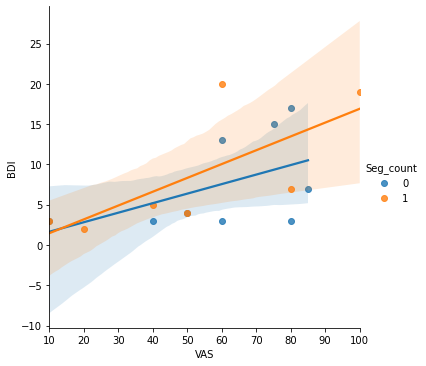

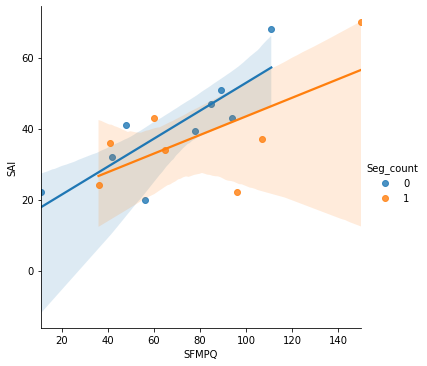

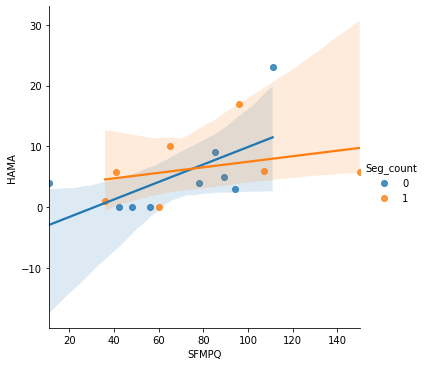

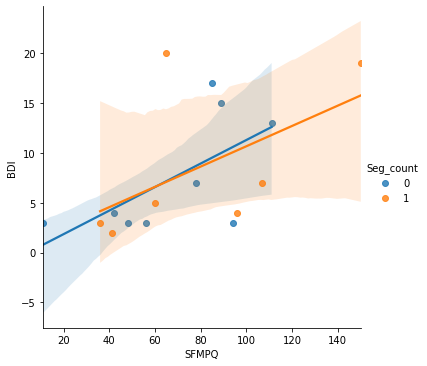

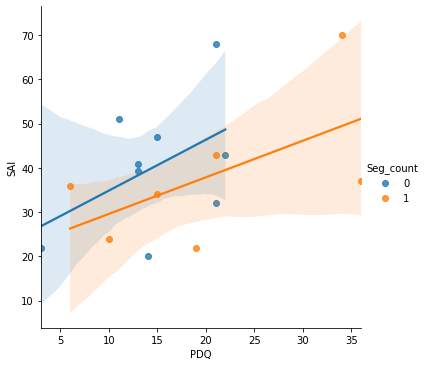

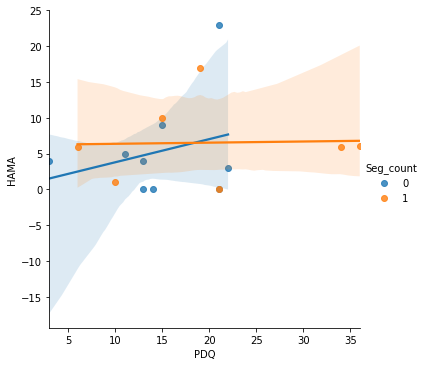

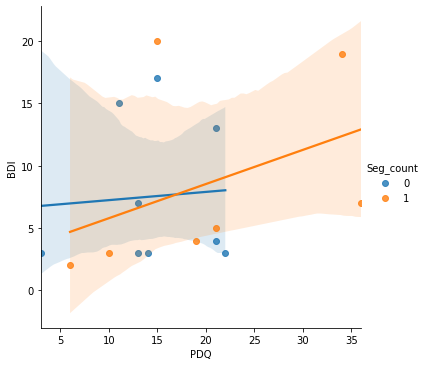

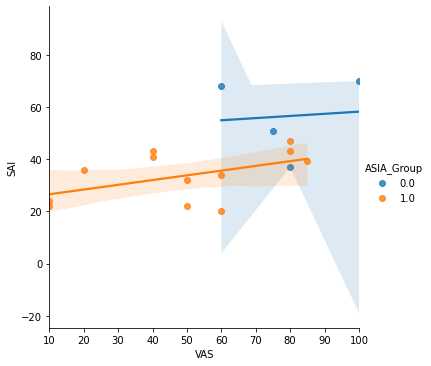

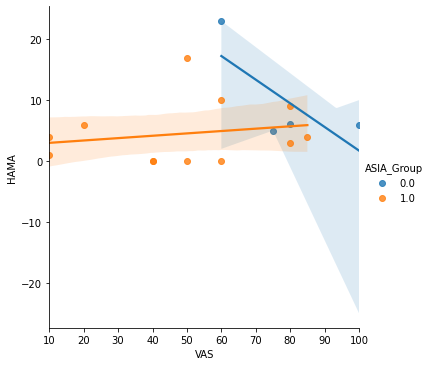

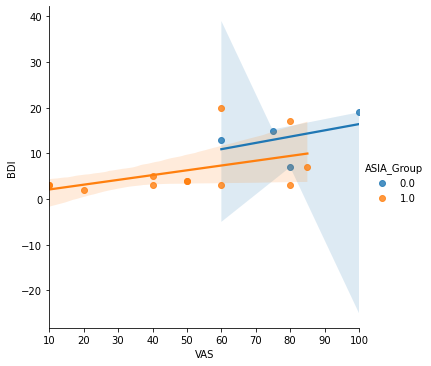

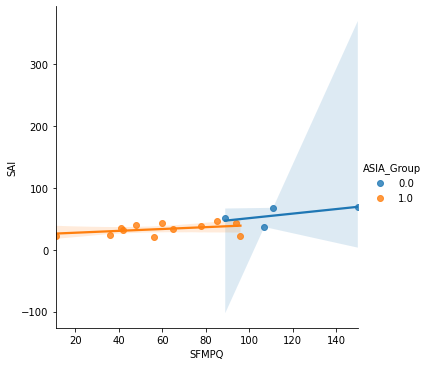

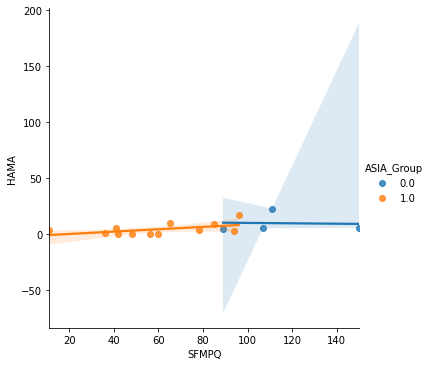

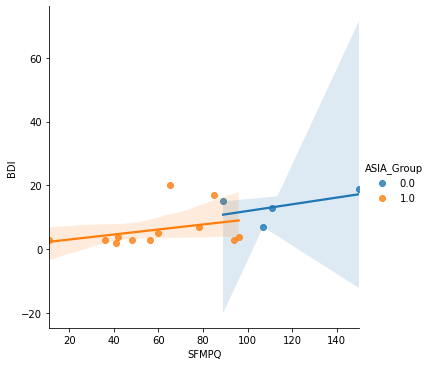

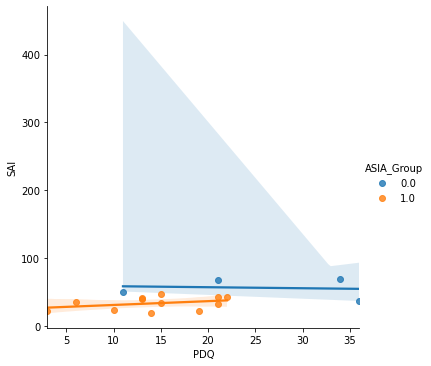

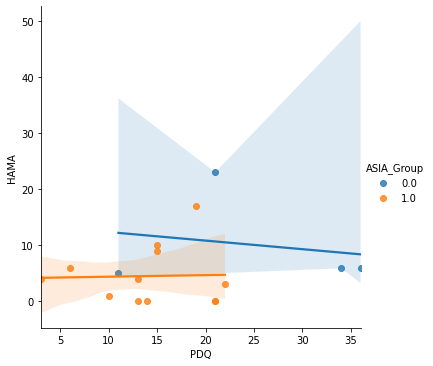

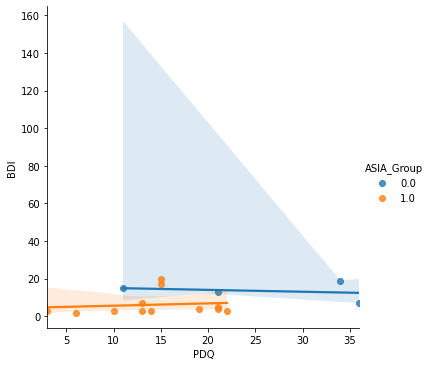

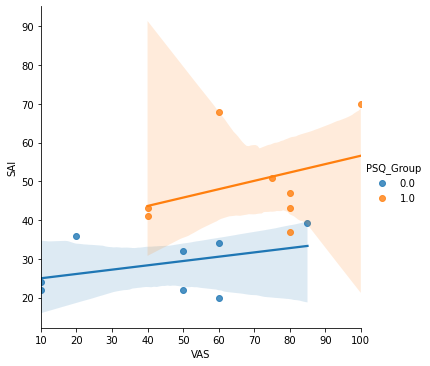

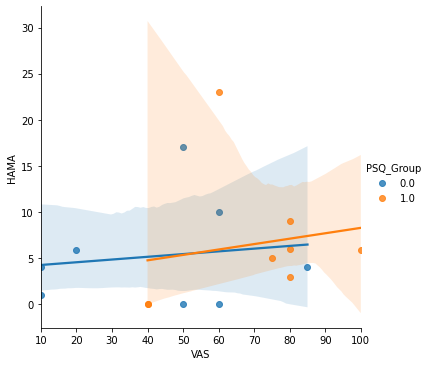

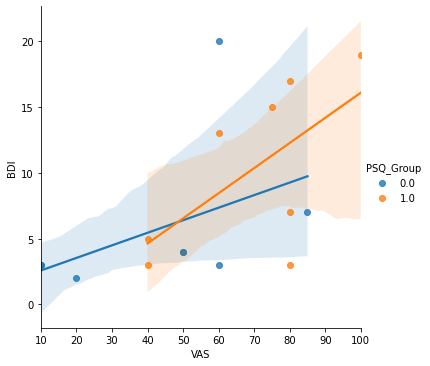

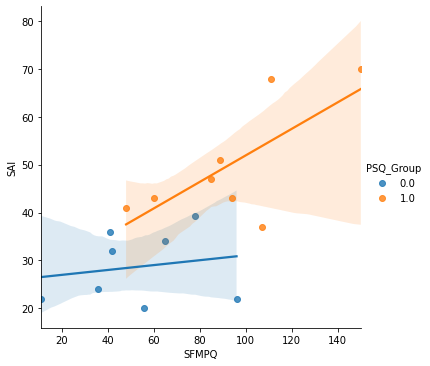

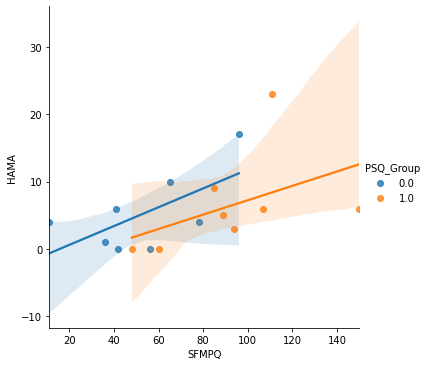

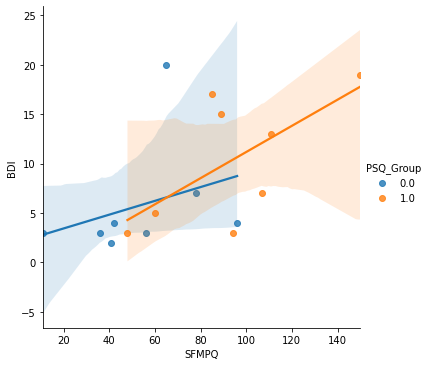

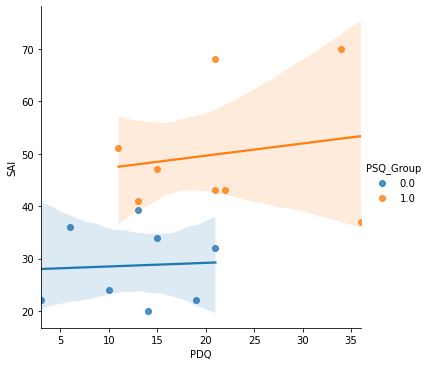

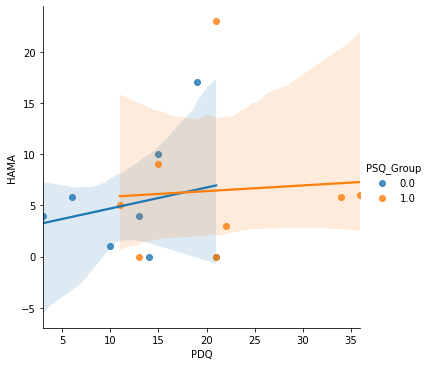

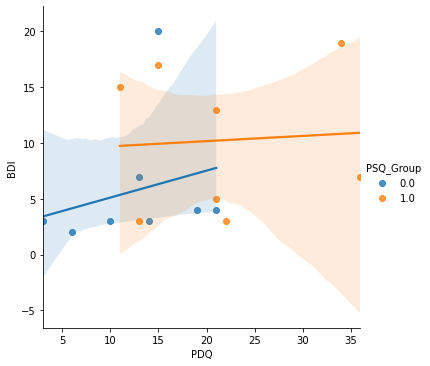

In [11]:
position = []
for cov in ['Injured_seg', 'Seg_count', 'ASIA_Group', 'PSQ_Group']:
    i = 1
    for pain in ['VAS', 'SFMPQ', 'PDQ']:
        j = 1
        for emotion in ['SAI', 'HAMA', 'BDI']:
            # statistic examination
            # res = ols("{0}~{1}+C({2})+{1}*C({2})".format(emotion,pain,cov), data = Scale_corr_1).fit()
            # print(res.summary())
            position.append((i,j))
            sns.lmplot(y=emotion, x = pain, hue = cov, data=Scale_corr_1)
            plt.savefig('forplot/{}{}{}.png'.format(cov,i,j), bbox_inches='tight')
            j += 1
        i += 1

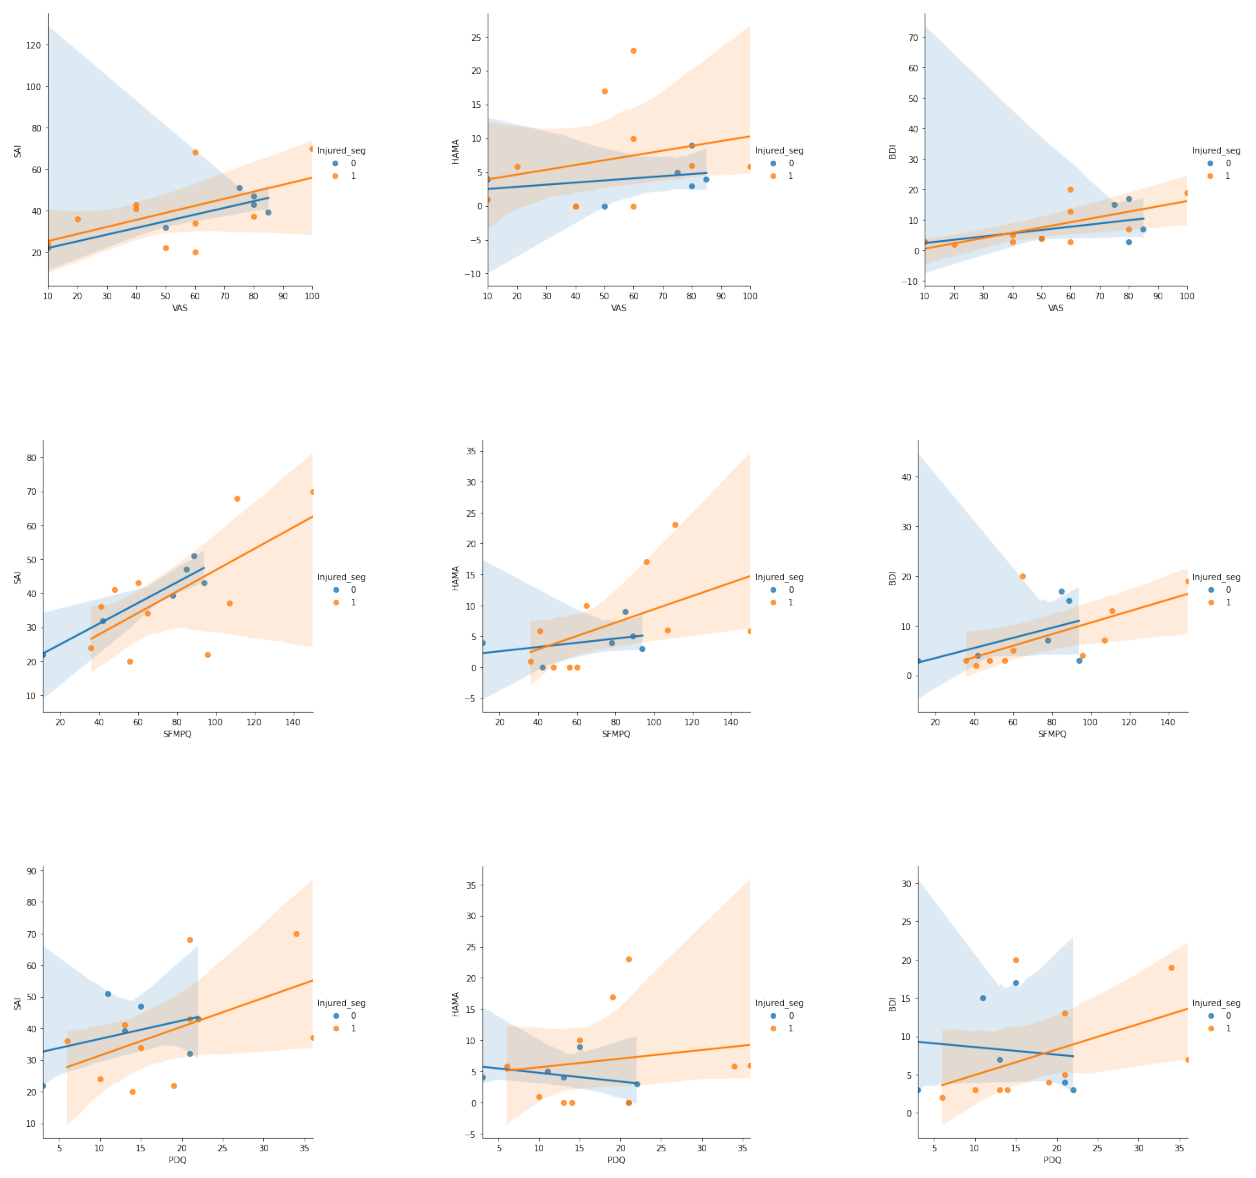

In [12]:
plt.figure(figsize=(20,20), dpi= 80)

pos = 1
for i,j in position[:9]:
    plt.subplot(3,3,pos)
    sns.set_style("white")
    plt.axis('off')
    im = plt.imread('forplot/{}{}{}.png'.format('Injured_seg',i,j))
    plt.imshow(im)
    pos += 1

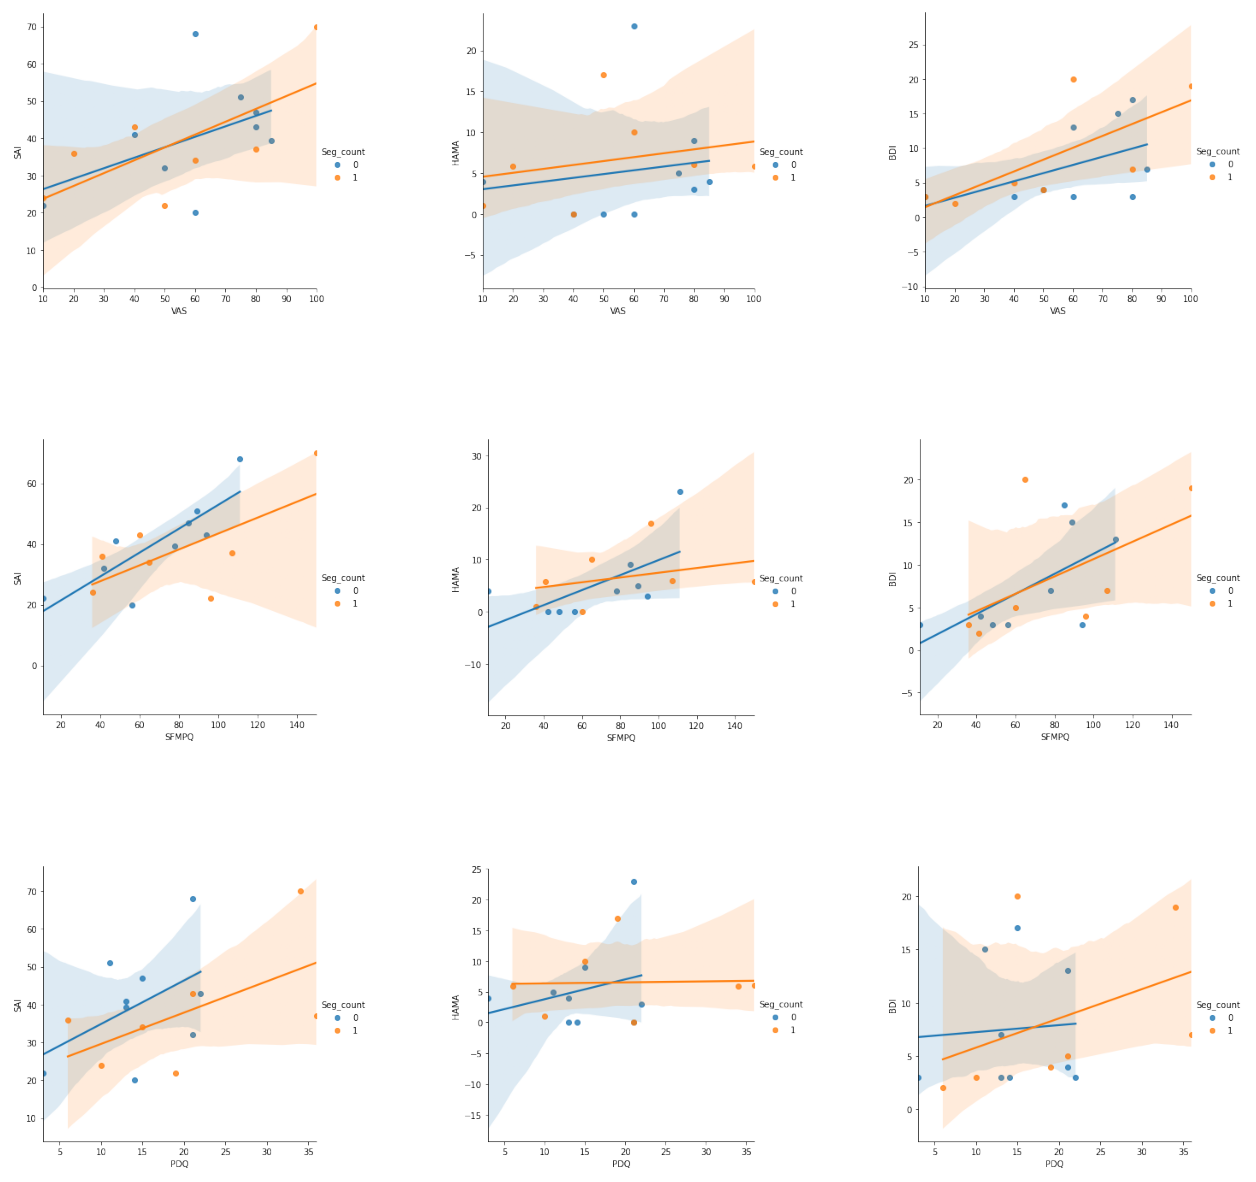

In [13]:
plt.figure(figsize=(20,20), dpi= 80)

pos = 1
for i,j in position[:9]:
    plt.subplot(3,3,pos)
    sns.set_style("white")
    plt.axis('off')
    im = plt.imread('forplot/{}{}{}.png'.format('Seg_count',i,j))
    plt.imshow(im)
    pos += 1

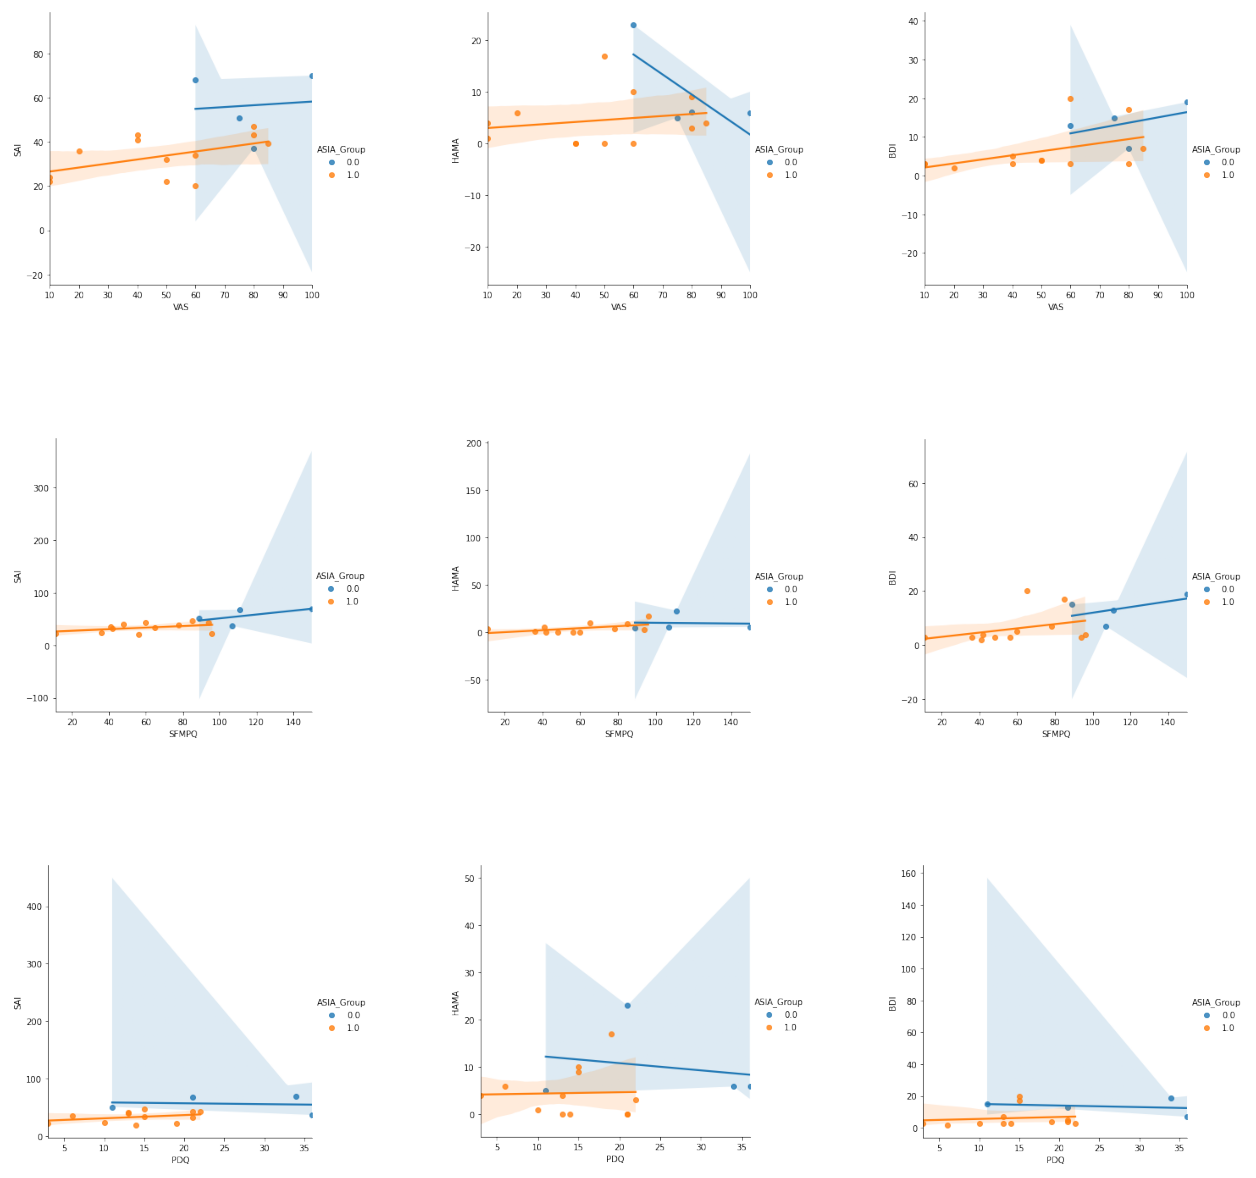

In [14]:
plt.figure(figsize=(20,20), dpi= 80)

pos = 1
for i,j in position[:9]:
    plt.subplot(3,3,pos)
    sns.set_style("white")
    plt.axis('off')
    im = plt.imread('forplot/{}{}{}.png'.format('ASIA_Group',i,j))
    plt.imshow(im)
    pos += 1

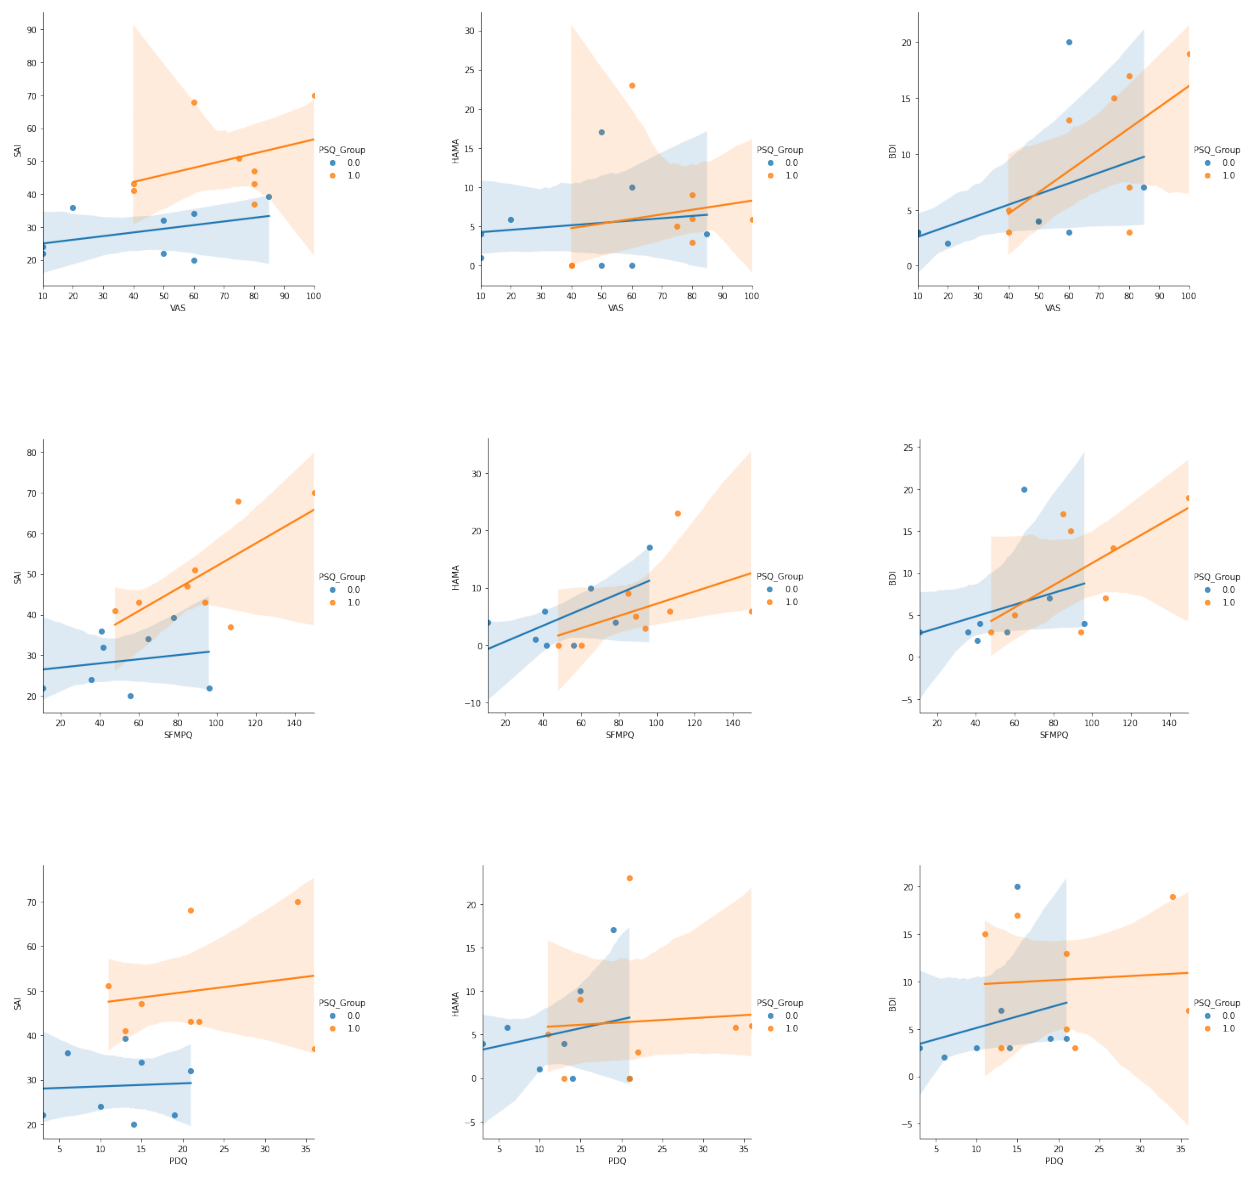

In [15]:
plt.figure(figsize=(20,20), dpi= 80)

pos = 1
for i,j in position[:9]:
    plt.subplot(3,3,pos)
    sns.set_style("white")
    plt.axis('off')
    im = plt.imread('forplot/{}{}{}.png'.format('PSQ_Group',i,j))
    plt.imshow(im)
    pos += 1

# 中介效应

In [16]:
print(Scale_corr_1.index)
Scale_corr_1.head(3)

Index(['P_003', 'P_004', 'P_006', 'P_007', 'P_013', 'P_014', 'P_015', 'P_016',
       'P_018', 'P_019', 'P_020', 'P_021', 'P_022', 'P_023', 'P_024', 'P_027'],
      dtype='object', name='ID')


,timepoint,VAS,SFMPQ,PDQ,PSQ,FPQ_Severe,FPQ_Mild,FPQ_Medical,FPQ_Total,PCS_1,...,BDI,LOT_R,PSQI,Age,ASIA,Injured_seg,Seg_count,Treatment,ASIA_Group,PSQ_Group
ID,,,,,,,,,,,,,,,,,,,,,
P_003,1,50.0,96.0,19.0,41.00,15.00,16.00,18.00,49.00,11.00,...,4.0,26.0,4.0,71,D,1,1,3,1.0,0.0
P_004,1,100.0,150.0,34.0,68.93,32.27,20.18,24.73,77.18,6.64,...,19.0,21.7,4.5,50,C,1,1,1,0.0,1.0
P_006,1,10.0,11.0,3.0,53.00,33.00,14.00,19.00,66.00,6.00,...,3.0,24.0,2.0,68,D,0,0,0,1.0,0.0


    * ``'path'``: regression model
    * ``'coef'``: regression estimates
    * ``'se'``: standard error
    * ``'CI[2.5%]'``: lower confidence interval
    * ``'CI[97.5%]'``: upper confidence interval
    * ``'pval'``: two-sided p-values
    * ``'sig'``: statistical significance

In [17]:
pg.mediation_analysis(data=Scale_corr_1, x='VAS', m='PSQ', y='SAI', n_boot=nreps)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,PSQ ~ X,0.648338,0.243299,0.018488,0.126513,1.170162,Yes
1,Y ~ PSQ,0.228881,0.115545,0.067601,-0.018939,0.476701,No
2,Total,0.316393,0.119161,0.018838,0.060818,0.571969,Yes
3,Direct,0.253215,0.148780,0.112544,-0.068205,0.574634,No
4,Indirect,0.063179,0.099856,0.378800,-0.129975,0.286020,No


In [ ]:
pg.mediation_analysis(data=Scale_corr_1, x='VAS', m='PSQ', y='SAI', n_boot=nreps)